In [7]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils import data
import random
import open3d as o3d
import numpy as np
import torch.nn.functional as F
from datasets.shapenet_data_pc import cate_to_synsetid

class Uniform15KPC(Dataset):
    def __init__(
        self,
        root_dir,
        subdirs,
        tr_sample_size=10000,
        te_sample_size=10000,
        split="train",
        scale=1.0,
        normalize_per_shape=False,
        box_per_shape=False,
        random_subsample=False,
        normalize_std_per_axis=False,
        all_points_mean=None,
        all_points_std=None,
        input_dim=3,
        use_mask=False,
    ):
        """?

        Args:
            root_dir (_type_): _description_
            subdirs (_type_): _description_
            tr_sample_size (int, optional): _description_. Defaults to 10000.
            te_sample_size (int, optional): _description_. Defaults to 10000.
            split (str, optional): _description_. Defaults to "train".
            scale (float, optional): _description_. Defaults to 1.0.
            normalize_per_shape (bool, optional): _description_. Defaults to False.
            box_per_shape (bool, optional): _description_. Defaults to False.
            random_subsample (bool, optional): _description_. Defaults to False.
            normalize_std_per_axis (bool, optional): _description_. Defaults to False.
            all_points_mean (_type_, optional): _description_. Defaults to None.
            all_points_std (_type_, optional): _description_. Defaults to None.
            input_dim (int, optional): _description_. Defaults to 3.
            use_mask (bool, optional): _description_. Defaults to False.
        """
        self.root_dir = root_dir
        self.split = split
        self.in_tr_sample_size = tr_sample_size
        self.in_te_sample_size = te_sample_size
        self.subdirs = subdirs
        self.scale = scale
        self.random_subsample = random_subsample
        self.input_dim = input_dim
        self.use_mask = use_mask
        self.box_per_shape = box_per_shape

        self.all_cate_mids = []
        self.cate_idx_lst = []
        self.all_points = []
        for cate_idx, subd in enumerate(self.subdirs):
            # NOTE: [subd] here is synset id
            sub_path = os.path.join(root_dir, subd, self.split)
            if not os.path.isdir(sub_path):
                print("Directory missing : %s" % sub_path)
                continue

            all_mids = []
            for x in os.listdir(sub_path):
                if not x.endswith(".npy"):
                    continue
                all_mids.append(os.path.join(self.split, x[: -len(".npy")]))

            # NOTE: [mid] contains the split: i.e. "train/<mid>" or "val/<mid>" or "test/<mid>"
            for mid in all_mids:
                # obj_fname = os.path.join(sub_path, x)
                obj_fname = os.path.join(root_dir, subd, mid + ".npy")
                try:
                    point_cloud = np.load(obj_fname)  # (15k, 3)

                except Exception as e:
                    print(e)
                    continue

                self.all_points.append(point_cloud[np.newaxis, ...])
                self.cate_idx_lst.append(cate_idx)
                self.all_cate_mids.append((subd, mid))

        # Shuffle the index deterministically (based on the number of examples)
        self.shuffle_idx = list(range(len(self.all_points)))
        random.Random(38383).shuffle(self.shuffle_idx)
        self.cate_idx_lst = [self.cate_idx_lst[i] for i in self.shuffle_idx]
        self.all_points = [self.all_points[i] for i in self.shuffle_idx]
        self.all_cate_mids = [self.all_cate_mids[i] for i in self.shuffle_idx]

        # Normalization
        self.all_points = np.concatenate(self.all_points)  # (N, 15000, 3)
        self.all_points = self.all_points.transpose(0, 2, 1)
        self.normalize_per_shape = normalize_per_shape
        self.normalize_std_per_axis = normalize_std_per_axis
        if (
            all_points_mean is not None and all_points_std is not None
        ):  # using loaded dataset stats
            self.all_points_mean = all_points_mean
            self.all_points_std = all_points_std
        elif self.normalize_per_shape:  # per shape normalization
            B, N = self.all_points.shape[:2]
            self.all_points_mean = self.all_points.mean(axis=1).reshape(B, 1, input_dim)
            if normalize_std_per_axis:
                self.all_points_std = (
                    self.all_points.reshape(B, N, -1)
                    .std(axis=1)
                    .reshape(B, 1, input_dim)
                )
            else:
                self.all_points_std = (
                    self.all_points.reshape(B, -1).std(axis=1).reshape(B, 1, 1)
                )
        elif self.box_per_shape:
            B, N = self.all_points.shape[:2]
            self.all_points_mean = self.all_points.min(axis=1).reshape(B, 1, input_dim)

            self.all_points_std = self.all_points.max(axis=1).reshape(
                B, 1, input_dim
            ) - self.all_points.min(axis=1).reshape(B, 1, input_dim)

        else:  # normalize across the dataset
            self.all_points_mean = (
                self.all_points.reshape(-1, input_dim)
                .mean(axis=0)
                .reshape(1, 1, input_dim)
            )
            if normalize_std_per_axis:
                self.all_points_std = (
                    self.all_points.reshape(-1, input_dim)
                    .std(axis=0)
                    .reshape(1, 1, input_dim)
                )
            else:
                self.all_points_std = (
                    self.all_points.reshape(-1).std(axis=0).reshape(1, 1, 1)
                )

        self.all_points = (self.all_points - self.all_points_mean) / self.all_points_std
        self.test_points = self.all_points
        if self.box_per_shape:
            self.all_points = self.all_points - 0.5
            
        self.train_points = self.all_points

        self.tr_sample_size = min(10000, tr_sample_size)
        self.te_sample_size = min(5000, te_sample_size)
        print("Total number of data:%d" % len(self.train_points))
        print(
            "Min number of points: (train)%d (test)%d"
            % (self.tr_sample_size, self.te_sample_size)
        )
        assert self.scale == 1, "Scale (!= 1) is deprecated"

    def get_pc_stats(self, idx):
        if self.normalize_per_shape or self.box_per_shape:
            m = self.all_points_mean[idx].reshape(1, self.input_dim)
            s = self.all_points_std[idx].reshape(1, -1)
            return m, s

        return self.all_points_mean.reshape(1, -1), self.all_points_std.reshape(1, -1)

    def renormalize(self, mean, std):
        self.all_points = self.all_points * self.all_points_std + self.all_points_mean
        self.all_points_mean = mean
        self.all_points_std = std
        self.all_points = (self.all_points - self.all_points_mean) / self.all_points_std
        self.train_points = self.all_points[:, :10000]
        self.test_points = self.all_points[:, 10000:]

    def __len__(self):
        return len(self.train_points)

    def __getitem__(self, idx):
        tr_out = self.train_points[idx]
        if self.random_subsample:
            tr_idxs = np.random.choice(tr_out.shape[0], self.tr_sample_size)
        else:
            tr_idxs = np.arange(self.tr_sample_size)
        tr_out = torch.from_numpy(tr_out[tr_idxs, :]).float()

        te_out = self.test_points[idx]
        if self.random_subsample:
            te_idxs = np.random.choice(te_out.shape[0], self.te_sample_size)
        else:
            te_idxs = np.arange(self.te_sample_size)
        te_out = torch.from_numpy(te_out[te_idxs, :]).float()

        m, s = self.get_pc_stats(idx)
        cate_idx = self.cate_idx_lst[idx]
        sid, mid = self.all_cate_mids[idx]

        out = {
            "idx": idx,
            "train_points": tr_out,
            "test_points": te_out,
            "mean": m,
            "std": s,
            "cate_idx": cate_idx,
            "sid": sid,
            "mid": mid,
        }

        if self.use_mask:
            # masked = torch.from_numpy(self.mask_transform(self.all_points[idx]))
            # ss = min(masked.shape[0], self.in_tr_sample_size//2)
            # masked = masked[:ss]
            #
            # tr_mask = torch.ones_like(masked)
            # masked = torch.cat([masked, torch.zeros(self.in_tr_sample_size - ss, 3)],dim=0)#F.pad(masked, (self.in_tr_sample_size-masked.shape[0], 0), "constant", 0)
            #
            # tr_mask =  torch.cat([tr_mask, torch.zeros(self.in_tr_sample_size- ss, 3)],dim=0)#F.pad(tr_mask, (self.in_tr_sample_size-tr_mask.shape[0], 0), "constant", 0)
            # out['train_points_masked'] = masked
            # out['train_masks'] = tr_mask
            tr_mask = self.mask_transform(tr_out)
            out["train_masks"] = tr_mask

        return out

class ShapeNet15kPointClouds(Uniform15KPC):
    def __init__(
        self,
        root_dir="data/ShapeNetCore.v2.PC15k",
        categories=["airplane"],
        tr_sample_size=10000,
        te_sample_size=2048,
        split="train",
        scale=1.0,
        normalize_per_shape=False,
        normalize_std_per_axis=False,
        box_per_shape=False,
        random_subsample=False,
        all_points_mean=None,
        all_points_std=None,
        use_mask=False,
    ):
        self.root_dir = root_dir
        self.split = split
        assert self.split in ["train", "test", "val"]
        self.tr_sample_size = tr_sample_size
        self.te_sample_size = te_sample_size
        self.cates = categories
        if "all" in categories:
            self.synset_ids = list(cate_to_synsetid.values())
        else:
            self.synset_ids = [cate_to_synsetid[c] for c in self.cates]

        # assert 'v2' in root_dir, "Only supporting v2 right now."
        self.gravity_axis = 1
        self.display_axis_order = [0, 2, 1]

        super(ShapeNet15kPointClouds, self).__init__(
            root_dir,
            self.synset_ids,
            tr_sample_size=tr_sample_size,
            te_sample_size=te_sample_size,
            split=split,
            scale=scale,
            normalize_per_shape=normalize_per_shape,
            box_per_shape=box_per_shape,
            normalize_std_per_axis=normalize_std_per_axis,
            random_subsample=random_subsample,
            all_points_mean=all_points_mean,
            all_points_std=all_points_std,
            input_dim=3,
            use_mask=use_mask,
        )

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:20
Min number of points: (train)2048 (test)2048


In [3]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, batch_size=1, sampler=None, shuffle=True is None, num_workers=1, drop_last=True)

(2048, 3)


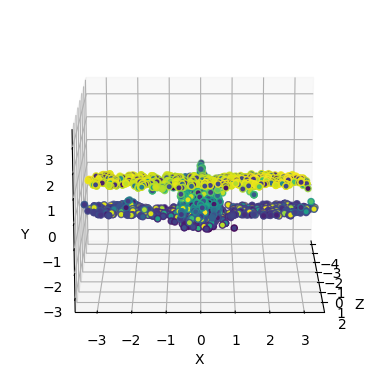

In [4]:
from visuals.visuals_util import visualize_pointcloud

for sample in train_dataloader:
    print(sample["train_points"][0].cpu().numpy().squeeze().shape)
    visualize_pointcloud(sample["train_points"].cpu().numpy().squeeze())
    break

In [9]:
from train_refinement import symmetry_loss

for sample in train_dataloader:
    xy = symmetry_loss(sample["train_points"].squeeze(), symmetry_plane='xy')
    xz = symmetry_loss(sample["train_points"].squeeze(), symmetry_plane='xz')
    yz = symmetry_loss(sample["train_points"].squeeze(), symmetry_plane='yz')
    
    print(f"XY: {xy.item():.4f}; XZ: {xz.item():.4f}; YZ: {yz.item():.4f}")

XY: 4.1682; XZ: 1.3700; YZ: 9.2744
XY: 5.5026; XZ: 0.3460; YZ: 4.2547
XY: 6.7677; XZ: 0.4784; YZ: 3.3288
XY: 7.8092; XZ: 0.3762; YZ: 3.1013
XY: 3.4475; XZ: 0.0741; YZ: 4.9679
XY: 6.4987; XZ: 0.1519; YZ: 2.3200
XY: 8.2929; XZ: 0.1587; YZ: 2.1623
XY: 1.6076; XZ: 0.0834; YZ: 3.0095
XY: 13.0475; XZ: 0.0929; YZ: 3.3819
XY: 8.4015; XZ: 0.2267; YZ: 2.5258
XY: 7.7762; XZ: 0.3355; YZ: 8.7636
XY: 14.4411; XZ: 0.2408; YZ: 1.5931
XY: 9.2099; XZ: 0.0964; YZ: 5.9863
XY: 9.5372; XZ: 0.2349; YZ: 2.6439
XY: 6.4901; XZ: 0.9201; YZ: 3.0882
XY: 7.3834; XZ: 0.4989; YZ: 3.3883
XY: 5.2699; XZ: 0.1432; YZ: 5.8638
XY: 5.0350; XZ: 0.1297; YZ: 6.1624
XY: 10.5435; XZ: 0.2445; YZ: 3.3290
XY: 5.1850; XZ: 0.1751; YZ: 5.3642


In [10]:
from scipy.spatial import cKDTree
from train_refinement import smoothness_loss
import torch

def find_neighbors(point_cloud, k=16):
    # Convert tensor to numpy array for cKDTree
    point_cloud_np = point_cloud.detach().cpu().numpy()
    tree = cKDTree(point_cloud_np)
    # Query the tree for the k nearest neighbors
    _, indices = tree.query(point_cloud_np, k=k+1)  # k+1 because the point itself is included
    # Convert to tensor (skip the first column which is the point itself)
    neighbors_indices = torch.from_numpy(indices[:, 1:]).to(point_cloud.device)
    return neighbors_indices

for sample in train_dataloader:
    point_cloud = sample["train_points"].squeeze()  # Assuming point_cloud shape is (2048, 3)
    neighbors = find_neighbors(point_cloud)
    smoothness = smoothness_loss(point_cloud, neighbors)
    print(f"Smoothness Loss: {smoothness.item():.4f}")


Smoothness Loss: 0.8032
Smoothness Loss: 0.4013
Smoothness Loss: 0.3165
Smoothness Loss: 0.5189
Smoothness Loss: 0.3232
Smoothness Loss: 0.2582
Smoothness Loss: 0.2938
Smoothness Loss: 0.1850
Smoothness Loss: 0.4503
Smoothness Loss: 0.2881
Smoothness Loss: 0.3994
Smoothness Loss: 0.5072
Smoothness Loss: 0.3958
Smoothness Loss: 0.5406
Smoothness Loss: 0.3934
Smoothness Loss: 0.4403
Smoothness Loss: 0.3841
Smoothness Loss: 0.4173
Smoothness Loss: 0.3100
Smoothness Loss: 0.3242


In [11]:
from train_refinement import composite_loss
lambda_smooth = 1.0
lambda_symmetry = 1.0

for sample in train_dataloader:
    point_cloud = sample["train_points"].squeeze()  # Assuming point_cloud shape is (2048, 3)
    neighbors = find_neighbors(point_cloud)
    smoothness = composite_loss(point_cloud, neighbors, lambda_smooth, lambda_symmetry, symmetry_plane="xz")
    print(f"Composite Loss: {smoothness.item():.4f}")

Composite Loss: 2.1112
Composite Loss: 0.7413
Composite Loss: 0.7766
Composite Loss: 0.8874
Composite Loss: 0.4155
Composite Loss: 0.4183
Composite Loss: 0.4628
Composite Loss: 0.2704
Composite Loss: 0.5518
Composite Loss: 0.4947
Composite Loss: 0.7494
Composite Loss: 0.7397
Composite Loss: 0.4848
Composite Loss: 0.7643
Composite Loss: 1.3075
Composite Loss: 0.9230
Composite Loss: 0.5077
Composite Loss: 0.5485
Composite Loss: 0.5313
Composite Loss: 0.5112


In [17]:
from model.pvcnn_completion import PVCNN2Base

class PVCNN2(PVCNN2Base):
    sa_blocks = [
        ((32, 2, 32), (1024, 0.1, 32, (32, 64))),
        ((64, 3, 16), (256, 0.2, 32, (64, 128))),
        ((128, 3, 8), (64, 0.4, 32, (128, 256))),
        (None, (16, 0.8, 32, (256, 256, 512))),
    ]
    fp_blocks = [
        ((256, 256), (256, 3, 8)),
        ((256, 256), (256, 3, 8)),
        ((256, 128), (128, 2, 16)),
        ((128, 128, 64), (64, 2, 32)),
    ]

    def __init__(self, num_classes, embed_dim, use_att,dropout, extra_feature_channels=3, width_multiplier=1,
                 voxel_resolution_multiplier=1):
        super().__init__(
            num_classes=num_classes, embed_dim=embed_dim, use_att=use_att,
            dropout=dropout, extra_feature_channels=extra_feature_channels,
            width_multiplier=width_multiplier, voxel_resolution_multiplier=voxel_resolution_multiplier, sv_points=None
        )

In [80]:
model = PVCNN2(num_classes=3, embed_dim=64, use_att=True, dropout=0.1, extra_feature_channels=0)
model = model.to("cuda")

In [48]:
from train_refinement import composite_loss
import torch.optim as optim
lambda_smooth = 1.0
lambda_symmetry = 1.0

optimizer= optim.Adam(model.parameters(), lr=2e-4, weight_decay=0)

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

for sample in train_dataloader:
    point_cloud = sample["train_points"].to("cuda").transpose(1,2).to("cuda")  # Assuming point_cloud shape is (2048, 3)
    
    output = model(point_cloud, torch.zeros(1).to("cuda")).to("cuda")

    neighbors = find_neighbors(output.squeeze().transpose(0,1))
    loss = composite_loss(output.squeeze().transpose(0,1), neighbors, lambda_smooth, lambda_symmetry, symmetry_plane="xz")
    print(f"Composite Loss: {loss.item():.4f}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    break

Composite Loss: 0.4459


In [49]:
output_np = output.squeeze().transpose(0, 1).detach().cpu().numpy()
output_np.shape

(2048, 3)

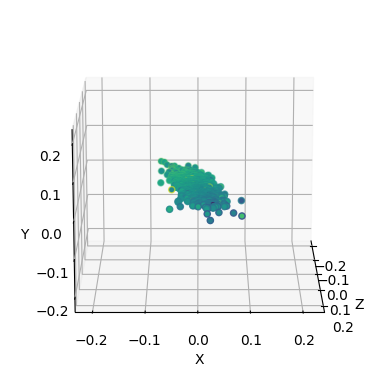

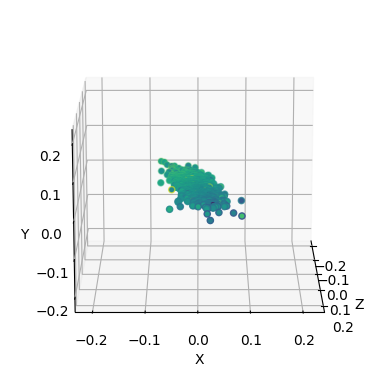

In [30]:
from visuals.visuals_util import visualize_pointcloud

visualize_pointcloud(output_np)

In [51]:
output_np = point_cloud.squeeze().transpose(0, 1).detach().cpu().numpy()
output_np.shape

(2048, 3)

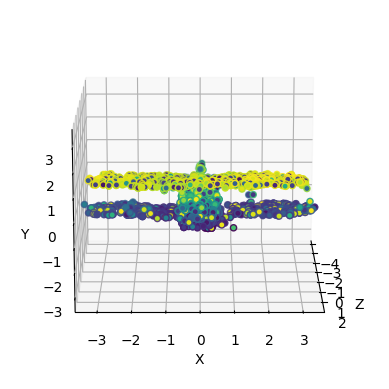

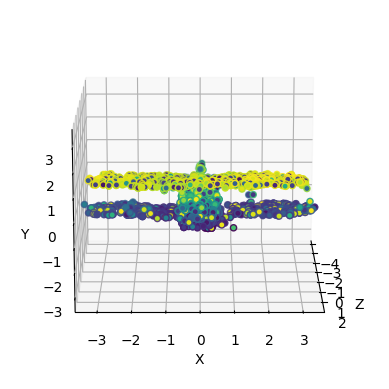

In [52]:
from visuals.visuals_util import visualize_pointcloud

visualize_pointcloud(output_np)

In [12]:
def chamfer_distance(p1, p2):
    p1 = p1.unsqueeze(1)  # Shape (B, 1, N, 3)
    p2 = p2.unsqueeze(2)  # Shape (B, M, 1, 3)
    distance = torch.sum((p1 - p2) ** 2, dim=-1)  # Shape (B, M, N)
    return torch.mean(torch.min(distance, dim=1)[0]) + torch.mean(torch.min(distance, dim=2)[0])

In [55]:
for sample in train_dataloader:
    point_cloud = sample["train_points"].to("cuda").transpose(1, 2)

    optimizer.zero_grad()

    output = model(point_cloud, torch.zeros(1).to("cuda")).to("cuda")
    output = output.squeeze().transpose(0, 1)

    neighbors = find_neighbors(output)
    refinement_loss = composite_loss(output, neighbors, lambda_smooth, lambda_symmetry, symmetry_plane="xz")
    reconstruction_loss = chamfer_distance(point_cloud, output)

    # Combine the losses
    total_loss = 0.1 * refinement_loss + 0.9 * reconstruction_loss

    print(f"Total Loss: {total_loss.item():.4f}")

    total_loss.backward()
    optimizer.step()

Total Loss: 3182.9951
Total Loss: 1904.0071
Total Loss: 1904.7836
Total Loss: 2132.4160
Total Loss: 1678.9753
Total Loss: 1735.2542
Total Loss: 2009.1848
Total Loss: 1002.8480
Total Loss: 1944.8523
Total Loss: 2102.3164
Total Loss: 2690.1755
Total Loss: 2099.1248
Total Loss: 2627.7878
Total Loss: 2390.3376
Total Loss: 2313.1646
Total Loss: 2293.7419
Total Loss: 2088.5720
Total Loss: 1845.2180
Total Loss: 2224.6511
Total Loss: 1987.1289


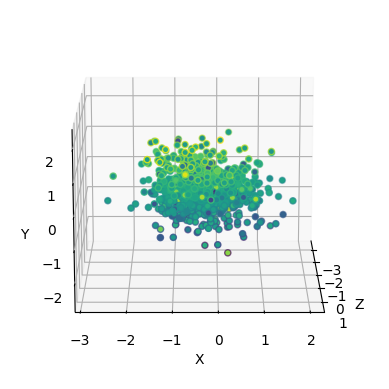

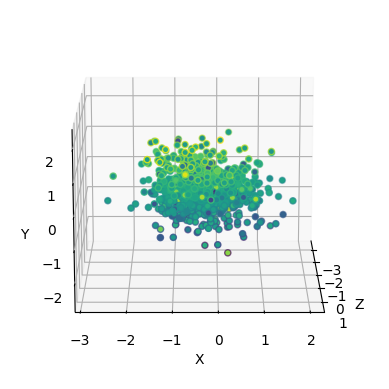

In [64]:
output_np = output.squeeze().detach().cpu().numpy()
visualize_pointcloud(output_np.transpose(0,1))

In [81]:
# Extract one sample from the dataloader
one_sample = next(iter(train_dataloader))
point_cloud = one_sample["train_points"].to("cuda").transpose(1, 2)

optimizer= optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

model.train()
# Run a fixed number of iterations with this sample
for iteration in range(100):  # Define number_of_iterations
    optimizer.zero_grad()

    output = model(point_cloud, torch.zeros(1).to("cuda")).to("cuda")
    output = output.squeeze().transpose(0, 1)

    # neighbors = find_neighbors(output)
    # refinement_loss = composite_loss(output, neighbors, lambda_smooth, lambda_symmetry, symmetry_plane="xz")
    total_loss = chamfer_distance(point_cloud, output)

    # Combine the losses
    # total_loss = 0.1 * refinement_loss + 0.9 * reconstruction_loss

    print(f"Iteration {iteration}, Total Loss: {total_loss.item():.4f}")

    total_loss.backward()
    optimizer.step()


Iteration 0, Total Loss: 3423.1243
Iteration 1, Total Loss: 3336.7251
Iteration 2, Total Loss: 3342.0386
Iteration 3, Total Loss: 3305.0166
Iteration 4, Total Loss: 3309.3440
Iteration 5, Total Loss: 3322.3513
Iteration 6, Total Loss: 3296.0564
Iteration 7, Total Loss: 3295.3909
Iteration 8, Total Loss: 3270.9832
Iteration 9, Total Loss: 3275.6201
Iteration 10, Total Loss: 3259.3179
Iteration 11, Total Loss: 3250.4314
Iteration 12, Total Loss: 3248.7490
Iteration 13, Total Loss: 3237.2776
Iteration 14, Total Loss: 3246.1313
Iteration 15, Total Loss: 3233.4814
Iteration 16, Total Loss: 3234.1802
Iteration 17, Total Loss: 3237.5781
Iteration 18, Total Loss: 3225.3745
Iteration 19, Total Loss: 3224.9265
Iteration 20, Total Loss: 3223.8601
Iteration 21, Total Loss: 3223.2764
Iteration 22, Total Loss: 3220.0024
Iteration 23, Total Loss: 3224.3433
Iteration 24, Total Loss: 3215.1038
Iteration 25, Total Loss: 3219.4331
Iteration 26, Total Loss: 3219.5337
Iteration 27, Total Loss: 3218.2334
It

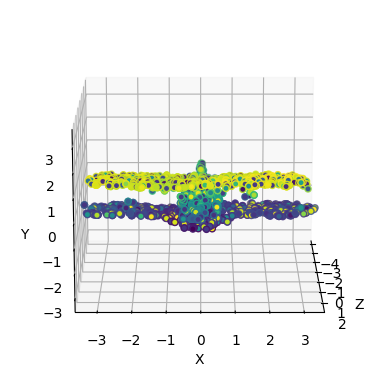

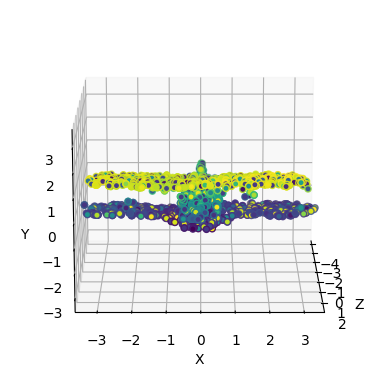

In [78]:
output_np = point_cloud.squeeze().transpose(0, 1).detach().cpu().numpy()
visualize_pointcloud(output_np.transpose(0,1))

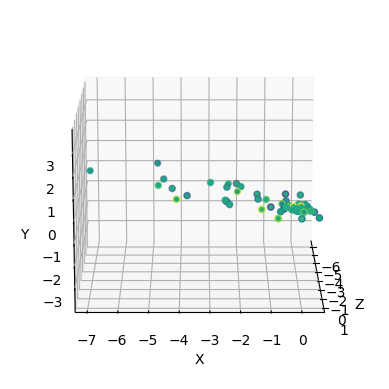

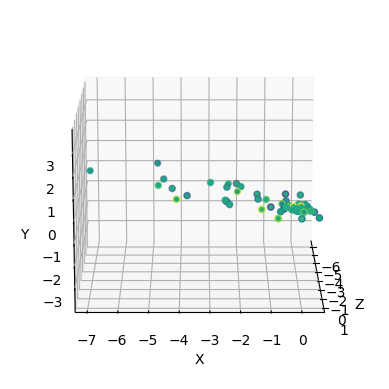

In [79]:
output_np = output.squeeze().detach().cpu().numpy()
visualize_pointcloud(output_np.transpose(0,1))

In [73]:
print(chamfer_distance(point_cloud, point_cloud))

tensor(0., device='cuda:0')


In [31]:
import torch.nn as nn
from modules.shared_mlp import SharedMLP
import modules.functional as F

class BallQuery(nn.Module):
    def __init__(self, radius, num_neighbors, include_coordinates=True):
        super().__init__()
        self.radius = radius
        self.num_neighbors = num_neighbors
        self.include_coordinates = include_coordinates

    def forward(self, points_coords, centers_coords, points_features=None):
        points_coords = points_coords.contiguous()
        centers_coords = centers_coords.contiguous()
        neighbor_indices = F.ball_query(centers_coords, points_coords, self.radius, self.num_neighbors)
        neighbor_coordinates = F.grouping(points_coords, neighbor_indices)
        neighbor_coordinates = neighbor_coordinates - centers_coords.unsqueeze(-1)

        if points_features is None:
            assert self.include_coordinates, 'No Features For Grouping'
            neighbor_features = neighbor_coordinates
        else:
            neighbor_features = F.grouping(points_features, neighbor_indices)
            if self.include_coordinates:
                neighbor_features = torch.cat([neighbor_coordinates, neighbor_features], dim=1)
        return neighbor_features

    def extra_repr(self):
        return 'radius={}, num_neighbors={}{}'.format(
            self.radius, self.num_neighbors, ', include coordinates' if self.include_coordinates else '')


class PointNetSAModule(nn.Module):
    def __init__(self, num_centers, radius, num_neighbors, in_channels, out_channels, include_coordinates=True):
        super().__init__()
        if not isinstance(radius, (list, tuple)):
            radius = [radius]
        if not isinstance(num_neighbors, (list, tuple)):
            num_neighbors = [num_neighbors] * len(radius)
        assert len(radius) == len(num_neighbors)
        if not isinstance(out_channels, (list, tuple)):
            out_channels = [[out_channels]] * len(radius)
        elif not isinstance(out_channels[0], (list, tuple)):
            out_channels = [out_channels] * len(radius)
        assert len(radius) == len(out_channels)

        groupers, mlps = [], []
        total_out_channels = 0
        for _radius, _out_channels, _num_neighbors in zip(radius, out_channels, num_neighbors):
            groupers.append(
                BallQuery(radius=_radius, num_neighbors=_num_neighbors, include_coordinates=include_coordinates)
            )
            mlps.append(
                SharedMLP(in_channels=in_channels + (3 if include_coordinates else 0),
                          out_channels=_out_channels, dim=2)
            )
            total_out_channels += _out_channels[-1]

        self.num_centers = num_centers
        self.out_channels = total_out_channels
        self.groupers = nn.ModuleList(groupers)
        self.mlps = nn.ModuleList(mlps)
        self.include_coordinates = include_coordinates

    def forward(self, inputs):
        features, coords = inputs
        centers_coords = F.furthest_point_sample(coords, self.num_centers)
        features_list = []
        for grouper, mlp in zip(self.groupers, self.mlps):
            grouped_features = grouper(coords, centers_coords, features)  # This now returns only features
            mlp_input = torch.cat([grouped_features, coords], dim=1) if self.include_coordinates else grouped_features
            mlp_output = mlp(mlp_input)
            features_list.append(mlp_output.max(dim=-1).values)
        if len(features_list) > 1:
            return features_list[0], centers_coords
        else:
            return features_list[0], centers_coords

    def extra_repr(self):
        return f'num_centers={self.num_centers}, out_channels={self.out_channels}'


class PointNetFPModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp = SharedMLP(in_channels=in_channels, out_channels=out_channels, dim=1)

    def forward(self, inputs):
        points_coords, centers_coords, centers_features = inputs
        points_features = None if len(inputs) == 3 else inputs[3]
        interpolated_features = F.nearest_neighbor_interpolate(points_coords, centers_coords, centers_features)
        if points_features is not None:
            interpolated_features = torch.cat([interpolated_features, points_features], dim=1)
        return self.mlp(interpolated_features), points_coords

class PointNetPlusPlus(nn.Module):
    def __init__(self, num_classes):
        super(PointNetPlusPlus, self).__init__()
        # Define the SA layers
        self.sa1 = PointNetSAModule(num_centers=512, radius=0.2, num_neighbors=32, in_channels=3, out_channels=[64, 64, 128])
        self.sa2 = PointNetSAModule(num_centers=128, radius=0.4, num_neighbors=64, in_channels=128, out_channels=[128, 128, 256])
        # Define the FP layers
        self.fp1 = PointNetFPModule(in_channels=384, out_channels=[256, 256])
        self.fp2 = PointNetFPModule(in_channels=256, out_channels=[128, 128])
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, xyz):
        # Set Abstraction layers
        l1_xyz, l1_features = self.sa1((xyz, xyz))
        l2_xyz, l2_features = self.sa2((l1_xyz, l1_features))

        # Feature Propagation layers
        fp1_features = self.fp1((l1_xyz, l2_xyz, l2_features))
        fp2_features = self.fp2((xyz, l1_xyz, fp1_features))

        # Classifier
        pred = self.classifier(fp2_features.view(fp2_features.size(0), -1))
        return pred


In [32]:
model = PointNetPlusPlus(3).to("cuda")

In [26]:
# Extract one sample from the dataloader
one_sample = next(iter(train_dataloader))
point_cloud = one_sample["train_points"].to("cuda").transpose(1, 2)
point_cloud.shape

torch.Size([1, 3, 2048])

In [33]:
import torch.optim as optim

optimizer= optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)
model.train()

# Run a fixed number of iterations with this sample
for iteration in range(100):  # Define number_of_iterations
    optimizer.zero_grad()

    output = model(point_cloud).to("cuda")
    output = output.squeeze().transpose(0, 1)

    # neighbors = find_neighbors(output)
    # refinement_loss = composite_loss(output, neighbors, lambda_smooth, lambda_symmetry, symmetry_plane="xz")
    total_loss = chamfer_distance(point_cloud, output)

    # Combine the losses
    # total_loss = 0.1 * refinement_loss + 0.9 * reconstruction_loss

    print(f"Iteration {iteration}, Total Loss: {total_loss.item():.4f}")

    total_loss.backward()
    optimizer.step()

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 512 but got size 2048 for tensor number 1 in the list.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Define the first linear layer
        self.linear1 = nn.Linear(2048, 2048)  # Assuming some arbitrary number of units

        # Define the second linear layer
        self.linear2 = nn.Linear(2048, 2048)  # Output size is 6144 (2048 points * 3 coordinates)

    def forward(self, x):
        # Apply the first linear layer
        x = self.linear1(x)

        # Apply ReLU
        x = F.relu(x)

        # Apply the second linear layer
        x = self.linear2(x)
        return x

In [31]:
model = SimpleNN().to("cuda")

def initialize_weight(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)

model.apply(initialize_weight)

SimpleNN(
  (linear1): Linear(in_features=2048, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=2048, bias=True)
)

In [15]:
# Extract one sample from the dataloader
one_sample = next(iter(train_dataloader))
point_cloud = one_sample["train_points"].to("cuda").transpose(1, 2)

In [13]:
point_cloud.shape

torch.Size([1, 3, 2048])

In [75]:
import torch.optim as optim
from train_refinement import composite_loss

optimizer= optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)
model.train()

lambda_smooth = 1.0
lambda_symmetry = 1.0

# Run a fixed number of iterations with this sample
for iteration in range(100):  # Define number_of_iterations

    for batch in train_dataloader:
        input = batch["train_points"].to("cuda").transpose(1,2)
        optimizer.zero_grad()

        output = model(input).to("cuda")
        output = output.squeeze()

        # neighbors = find_neighbors(output)
        # refinement_loss = composite_loss(output, neighbors, lambda_smooth, lambda_symmetry, symmetry_plane="xz")
        c_loss = chamfer_distance(input, output)
        s_loss = symmetry_loss(output.squeeze())

        total_loss = 0.1 * c_loss + 10 * s_loss
        # Combine the losses
        # total_loss = 0.1 * refinement_loss + 0.9 * reconstruction_loss

        print(f"Iteration {iteration}, Total Loss: {total_loss.item():.4f}")

        total_loss.backward()
        optimizer.step()

Iteration 0, Total Loss: 328.9270
Iteration 0, Total Loss: 385.2766
Iteration 1, Total Loss: 326.4476
Iteration 1, Total Loss: 378.6532
Iteration 2, Total Loss: 327.1380
Iteration 2, Total Loss: 379.0325
Iteration 3, Total Loss: 325.9643
Iteration 3, Total Loss: 378.3322
Iteration 4, Total Loss: 326.2837
Iteration 4, Total Loss: 380.8132
Iteration 5, Total Loss: 322.9272
Iteration 5, Total Loss: 380.1594
Iteration 6, Total Loss: 321.0946
Iteration 6, Total Loss: 378.1046
Iteration 7, Total Loss: 318.9590
Iteration 7, Total Loss: 381.4901
Iteration 8, Total Loss: 323.0048
Iteration 8, Total Loss: 376.0156
Iteration 9, Total Loss: 318.4421
Iteration 9, Total Loss: 374.7465
Iteration 10, Total Loss: 325.8068
Iteration 10, Total Loss: 381.6240
Iteration 11, Total Loss: 324.4074
Iteration 11, Total Loss: 376.0676
Iteration 12, Total Loss: 323.9329
Iteration 12, Total Loss: 375.0562
Iteration 13, Total Loss: 319.8300
Iteration 13, Total Loss: 368.3486
Iteration 14, Total Loss: 324.0965
Itera

torch.Size([3, 2048])


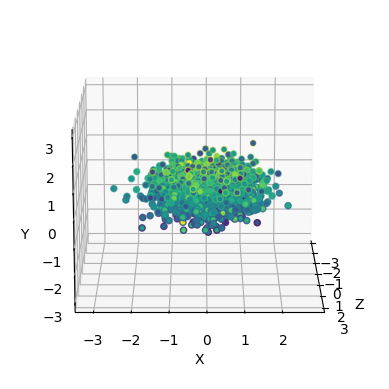

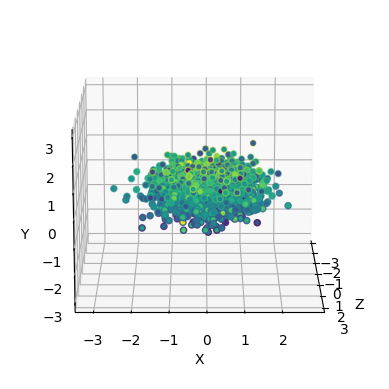

In [76]:
print(output[0].shape)
output_np = output[5].transpose(0,1).squeeze().detach().cpu().numpy()

visualize_pointcloud(output_np.transpose(0,1))

torch.Size([3, 2048])


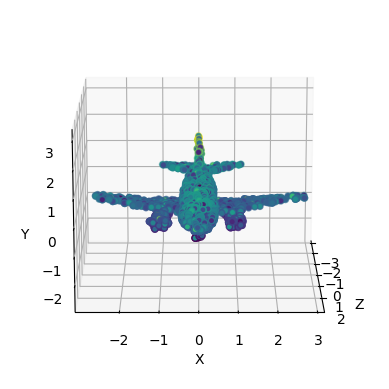

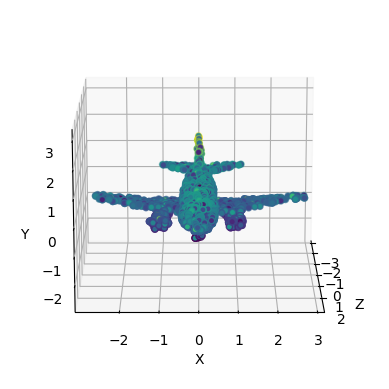

In [78]:
print(input[0].shape)
output_np = input[5].transpose(0,1).squeeze().detach().cpu().numpy()

visualize_pointcloud(output_np.transpose(0,1))

In [13]:
test_tensor = torch.load("./shapenet_airplane_pvd_closest_neighbour.pth")
test_tensor["train_points"].shape

torch.Size([2048, 3])

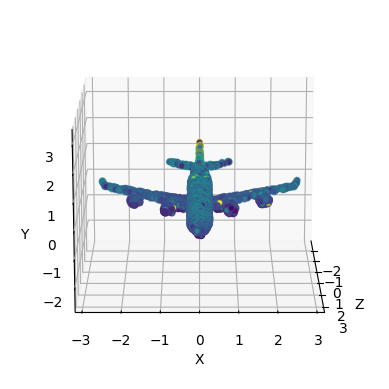

In [16]:
from visuals.visuals_util import visualize_pointcloud

fig = visualize_pointcloud(test_tensor["train_points"])

In [7]:
from metrics.ChamferDistancePytorch.chamfer_python import distChamfer
import torch

def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

B = 10
N = 2048
C = 3

xyz1 = torch.rand(B,N,C).to("cuda")
xyz1.requires_grad = True
xyz2 = torch.rand(B,N,C).to("cuda")
xyz2.requires_grad = True

result_cd = chamfer_distance(xyz1, xyz2)
result_cd

tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)

In [8]:
from metrics.ChamferDistancePytorch.fscore import fscore

def fscore_loss(dist1, dist2, threshold=0.001):
    fscores, _, _ = fscore(dist1, dist2, threshold)
    # Take the mean of fscore across the batch for a single loss value
    return 1 - torch.mean(fscores)

result_fscore = fscore_loss(xyz1, xyz2)
result_fscore

tensor(0.9992, device='cuda:0')

In [32]:
import torch.optim as optim
from train_refinement import composite_loss

optimizer= optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)
model.train()

# Run a fixed number of iterations with this sample
for iteration in range(1000):  # Define number_of_iterations
    optimizer.zero_grad()

    output = model(point_cloud).to("cuda")
    output = output.squeeze()
    total_loss = chamfer_distance(point_cloud, output[None, :, :])

    print(f"Iteration {iteration}, Total Loss: {total_loss.item():.4f}")

    total_loss.backward()
    optimizer.step()

Iteration 0, Total Loss: 4889.8047
Iteration 1, Total Loss: 3974.2839
Iteration 2, Total Loss: 3276.3826
Iteration 3, Total Loss: 2750.3835
Iteration 4, Total Loss: 2359.3328
Iteration 5, Total Loss: 2071.5273
Iteration 6, Total Loss: 1859.8215
Iteration 7, Total Loss: 1703.5747
Iteration 8, Total Loss: 1586.7883
Iteration 9, Total Loss: 1498.5420
Iteration 10, Total Loss: 1422.9392
Iteration 11, Total Loss: 1352.1467
Iteration 12, Total Loss: 1292.0176
Iteration 13, Total Loss: 1240.8256
Iteration 14, Total Loss: 1197.2220
Iteration 15, Total Loss: 1160.0378
Iteration 16, Total Loss: 1128.0554
Iteration 17, Total Loss: 1100.3624
Iteration 18, Total Loss: 1076.0125
Iteration 19, Total Loss: 1054.4132
Iteration 20, Total Loss: 1035.2363
Iteration 21, Total Loss: 1018.2316
Iteration 22, Total Loss: 1003.1031
Iteration 23, Total Loss: 989.6409
Iteration 24, Total Loss: 977.6713
Iteration 25, Total Loss: 967.0702
Iteration 26, Total Loss: 957.7263
Iteration 27, Total Loss: 949.5344
Iterati

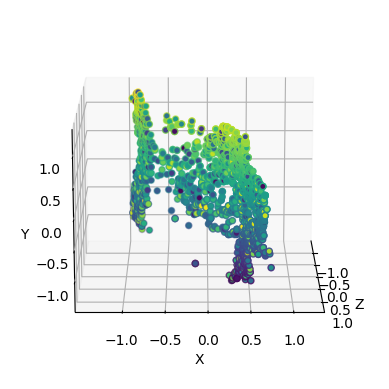

In [33]:
output_np = output.squeeze().detach().transpose(0,1).cpu().numpy()
fig = visualize_pointcloud(output_np)

In [9]:
train_loader_20 = torch.utils.data.DataLoader(tr_dataset, batch_size=20, sampler=None, shuffle=True is None, num_workers=1, drop_last=True)

In [10]:
for batch in train_loader_20:
    print(batch["train_points"].shape)

torch.Size([20, 2048, 3])


In [59]:
import torch.optim as optim

optimizer= optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)
model.train()

# Run a fixed number of iterations with this sample
for iteration in range(100):  # Define number_of_iterations
    for batch in train_loader_20:
        input = batch["train_points"].to("cuda").transpose(1,2)
        optimizer.zero_grad()
        output = model(input).to("cuda")
        total_loss = chamfer_distance(input, output)
        print(f"Iteration {iteration}, Total Loss: {total_loss.item():.4f}")

        total_loss.backward()
        optimizer.step()

Iteration 0, Total Loss: 768.4979
Iteration 1, Total Loss: 779.9353
Iteration 2, Total Loss: 780.2227
Iteration 3, Total Loss: 768.6763
Iteration 4, Total Loss: 768.9082
Iteration 5, Total Loss: 775.8480
Iteration 6, Total Loss: 768.1910
Iteration 7, Total Loss: 768.9116
Iteration 8, Total Loss: 765.7675
Iteration 9, Total Loss: 768.4835
Iteration 10, Total Loss: 764.4016
Iteration 11, Total Loss: 768.6785
Iteration 12, Total Loss: 776.1608
Iteration 13, Total Loss: 765.4709
Iteration 14, Total Loss: 764.5762
Iteration 15, Total Loss: 764.6309
Iteration 16, Total Loss: 757.4669
Iteration 17, Total Loss: 769.0395
Iteration 18, Total Loss: 759.0341
Iteration 19, Total Loss: 763.1038
Iteration 20, Total Loss: 762.1888
Iteration 21, Total Loss: 762.3513
Iteration 22, Total Loss: 765.5400
Iteration 23, Total Loss: 762.6081
Iteration 24, Total Loss: 765.8373
Iteration 25, Total Loss: 764.8269
Iteration 26, Total Loss: 757.5070
Iteration 27, Total Loss: 758.6001
Iteration 28, Total Loss: 765.

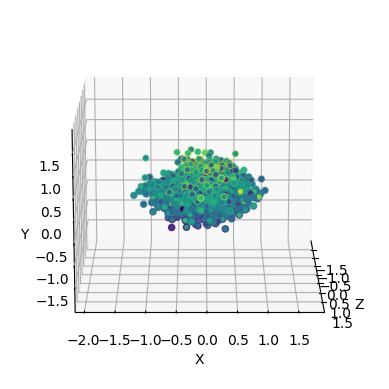

In [57]:
output_np = output[15, :, :].squeeze().detach().transpose(0,1).cpu().numpy()
fig = visualize_pointcloud(output_np)

# Let's try to use PointNet++ and PVCNN

In [97]:
import torch
import torch.nn as nn

import modules.functional as F
from modules.ball_query import BallQuery
from modules.shared_mlp import SharedMLP

class PointNetAModule(nn.Module):
    def __init__(self, in_channels, out_channels, include_coordinates=True):
        super().__init__()
        if not isinstance(out_channels, (list, tuple)):
            out_channels = [[out_channels]]
        elif not isinstance(out_channels[0], (list, tuple)):
            out_channels = [out_channels]

        mlps = []
        total_out_channels = 0
        for _out_channels in out_channels:
            mlps.append(
                SharedMLP(in_channels=in_channels + (3 if include_coordinates else 0),
                          out_channels=_out_channels, dim=1)
            )
            total_out_channels += _out_channels[-1]

        self.include_coordinates = include_coordinates
        self.out_channels = total_out_channels
        self.mlps = nn.ModuleList(mlps)

    def forward(self, inputs):
        features, coords = inputs
        if self.include_coordinates:
            features = torch.cat([features, coords], dim=1)
        coords = torch.zeros((coords.size(0), 3, 1), device=coords.device)
        if len(self.mlps) > 1:
            features_list = []
            for mlp in self.mlps:
                features_list.append(mlp(features).max(dim=-1, keepdim=True).values)
            return torch.cat(features_list, dim=1), coords
        else:
            return self.mlps[0](features).max(dim=-1, keepdim=True).values, coords

    def extra_repr(self):
        return f'out_channels={self.out_channels}, include_coordinates={self.include_coordinates}'


class PointNetSAModule(nn.Module):
    def __init__(self, num_centers, radius, num_neighbors, in_channels, out_channels, include_coordinates=True):
        super().__init__()
        if not isinstance(radius, (list, tuple)):
            radius = [radius]
        if not isinstance(num_neighbors, (list, tuple)):
            num_neighbors = [num_neighbors] * len(radius)
        assert len(radius) == len(num_neighbors)
        if not isinstance(out_channels, (list, tuple)):
            out_channels = [[out_channels]] * len(radius)
        elif not isinstance(out_channels[0], (list, tuple)):
            out_channels = [out_channels] * len(radius)
        assert len(radius) == len(out_channels)

        groupers, mlps = [], []
        total_out_channels = 0
        for _radius, _out_channels, _num_neighbors in zip(radius, out_channels, num_neighbors):
            groupers.append(
                BallQuery(radius=_radius, num_neighbors=_num_neighbors, include_coordinates=include_coordinates)
            )
            mlps.append(
                SharedMLP(in_channels=in_channels + (3 if include_coordinates else 0),
                          out_channels=_out_channels, dim=2)
            )
            total_out_channels += _out_channels[-1]

        self.num_centers = num_centers
        self.out_channels = total_out_channels
        self.groupers = nn.ModuleList(groupers)
        self.mlps = nn.ModuleList(mlps)

    def forward(self, inputs):
        features, coords = inputs
        centers_coords = F.furthest_point_sample(coords, self.num_centers)
        features_list = []
        for grouper, mlp in zip(self.groupers, self.mlps):
            features_list.append(mlp(grouper(coords, centers_coords, features)).max(dim=-1).values)
        if len(features_list) > 1:
            return torch.cat(features_list, dim=1), centers_coords
        else:
            return features_list[0], centers_coords

    def extra_repr(self):
        return f'num_centers={self.num_centers}, out_channels={self.out_channels}'


class PointNetFPModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp = SharedMLP(in_channels=in_channels, out_channels=out_channels, dim=1)

    def forward(self, inputs):
        if len(inputs) == 3:
            points_coords, centers_coords, centers_features = inputs
            points_features = None
        else:
            points_coords, centers_coords, centers_features, points_features = inputs
        interpolated_features = F.nearest_neighbor_interpolate(points_coords, centers_coords, centers_features)
        if points_features is not None:
            interpolated_features = torch.cat(
                [interpolated_features, points_features], dim=1
            )
        return self.mlp(interpolated_features), points_coords

In [98]:
import torch.nn as nn

import modules.functional as F
from modules.voxelization import Voxelization
from modules.shared_mlp import SharedMLP
from modules.se import SE3d

__all__ = ['PVConv']


class PVConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, resolution, with_se=False, normalize=True, eps=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.resolution = resolution

        self.voxelization = Voxelization(resolution, normalize=normalize, eps=eps)
        voxel_layers = [
            nn.Conv3d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm3d(out_channels, eps=1e-4),
            nn.LeakyReLU(0.1, True),
            nn.Conv3d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size // 2),
            nn.BatchNorm3d(out_channels, eps=1e-4),
            nn.LeakyReLU(0.1, True),
         ]
        if with_se:
            voxel_layers.append(SE3d(out_channels))
        self.voxel_layers = nn.Sequential(*voxel_layers)
        self.point_features = SharedMLP(in_channels, out_channels)

    def forward(self, inputs):
        features, coords = inputs
        voxel_features, voxel_coords = self.voxelization(features, coords)
        voxel_features = self.voxel_layers(voxel_features)
        voxel_features = F.trilinear_devoxelize(voxel_features, voxel_coords, self.resolution, self.training)
        fused_features = voxel_features + self.point_features(features)
        return fused_features, coords

In [99]:
import functools

from modules import SharedMLP


def _linear_bn_relu(in_channels, out_channels):
    return nn.Sequential(nn.Linear(in_channels, out_channels), nn.BatchNorm1d(out_channels), nn.ReLU(True))


def create_mlp_components(in_channels, out_channels, classifier=False, dim=2, width_multiplier=1):
    r = width_multiplier

    if dim == 1:
        block = _linear_bn_relu
    else:
        block = SharedMLP
    if not isinstance(out_channels, (list, tuple)):
        out_channels = [out_channels]
    if len(out_channels) == 0 or (len(out_channels) == 1 and out_channels[0] is None):
        return nn.Sequential(), in_channels, in_channels

    layers = []
    for oc in out_channels[:-1]:
        if oc < 1:
            layers.append(nn.Dropout(oc))
        else:
            oc = int(r * oc)
            layers.append(block(in_channels, oc))
            in_channels = oc
    if dim == 1:
        if classifier:
            layers.append(nn.Linear(in_channels, out_channels[-1]))
        else:
            layers.append(_linear_bn_relu(in_channels, int(r * out_channels[-1])))
    else:
        if classifier:
            layers.append(nn.Conv1d(in_channels, out_channels[-1], 1))
        else:
            layers.append(SharedMLP(in_channels, int(r * out_channels[-1])))
    return layers, out_channels[-1] if classifier else int(r * out_channels[-1])


def create_pointnet_components(blocks, in_channels, with_se=False, normalize=True, eps=0,
                               width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier

    layers, concat_channels = [], 0
    for out_channels, num_blocks, voxel_resolution in blocks:
        out_channels = int(r * out_channels)
        if voxel_resolution is None:
            block = SharedMLP
        else:
            block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                      with_se=with_se, normalize=normalize, eps=eps)
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels))
            in_channels = out_channels
            concat_channels += out_channels
    return layers, in_channels, concat_channels


def create_pointnet2_sa_components(sa_blocks, extra_feature_channels, with_se=False, normalize=True, eps=0,
                                   width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier
    in_channels = extra_feature_channels + 3

    sa_layers, sa_in_channels = [], []
    for conv_configs, sa_configs in sa_blocks:
        sa_in_channels.append(in_channels)
        sa_blocks = []
        if conv_configs is not None:
            out_channels, num_blocks, voxel_resolution = conv_configs
            out_channels = int(r * out_channels)
            if voxel_resolution is None:
                block = SharedMLP
            else:
                block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                          with_se=with_se, normalize=normalize, eps=eps)
            for _ in range(num_blocks):
                sa_blocks.append(block(in_channels, out_channels))
                in_channels = out_channels
            extra_feature_channels = in_channels
        num_centers, radius, num_neighbors, out_channels = sa_configs
        _out_channels = []
        for oc in out_channels:
            if isinstance(oc, (list, tuple)):
                _out_channels.append([int(r * _oc) for _oc in oc])
            else:
                _out_channels.append(int(r * oc))
        out_channels = _out_channels
        if num_centers is None:
            block = PointNetAModule
        else:
            block = functools.partial(PointNetSAModule, num_centers=num_centers, radius=radius,
                                      num_neighbors=num_neighbors)
        sa_blocks.append(block(in_channels=extra_feature_channels, out_channels=out_channels,
                               include_coordinates=True))
        in_channels = extra_feature_channels = sa_blocks[-1].out_channels
        if len(sa_blocks) == 1:
            sa_layers.append(sa_blocks[0])
        else:
            sa_layers.append(nn.Sequential(*sa_blocks))

    return sa_layers, sa_in_channels, in_channels, 1 if num_centers is None else num_centers


def create_pointnet2_fp_modules(fp_blocks, in_channels, sa_in_channels, with_se=False, normalize=True, eps=0,
                                width_multiplier=1, voxel_resolution_multiplier=1):
    r, vr = width_multiplier, voxel_resolution_multiplier

    fp_layers = []
    for fp_idx, (fp_configs, conv_configs) in enumerate(fp_blocks):
        fp_blocks = []
        out_channels = tuple(int(r * oc) for oc in fp_configs)
        fp_blocks.append(
            PointNetFPModule(in_channels=in_channels + sa_in_channels[-1 - fp_idx], out_channels=out_channels)
        )
        in_channels = out_channels[-1]
        if conv_configs is not None:
            out_channels, num_blocks, voxel_resolution = conv_configs
            out_channels = int(r * out_channels)
            if voxel_resolution is None:
                block = SharedMLP
            else:
                block = functools.partial(PVConv, kernel_size=3, resolution=int(vr * voxel_resolution),
                                          with_se=with_se, normalize=normalize, eps=eps)
            for _ in range(num_blocks):
                fp_blocks.append(block(in_channels, out_channels))
                in_channels = out_channels
        if len(fp_blocks) == 1:
            fp_layers.append(fp_blocks[0])
        else:
            fp_layers.append(nn.Sequential(*fp_blocks))

    return fp_layers, in_channels

In [100]:
import torch
import torch.nn as nn


class PVCNN(nn.Module):
    blocks = ((64, 1, 32), (128, 2, 16), (512, 1, None), (2048, 1, None))

    def __init__(self, num_classes, num_shapes, extra_feature_channels=3,
                 width_multiplier=1, voxel_resolution_multiplier=1):
        super().__init__()
        assert extra_feature_channels >= 0
        self.in_channels = extra_feature_channels + 3
        self.num_shapes = num_shapes

        layers, channels_point, concat_channels_point = create_pointnet_components(
            blocks=self.blocks, in_channels=self.in_channels, with_se=True, normalize=False,
            width_multiplier=width_multiplier, voxel_resolution_multiplier=voxel_resolution_multiplier
        )
        self.point_features = nn.ModuleList(layers)

        layers, _ = create_mlp_components(in_channels=(num_shapes + channels_point + concat_channels_point),
                                          out_channels=[256, 0.2, 256, 0.2, 128, num_classes],
                                          classifier=True, dim=2, width_multiplier=width_multiplier)
        self.classifier = nn.Sequential(*layers)

    def forward(self, inputs):
        # inputs : [B, in_channels + S, N]
        features = inputs[:, :self.in_channels, :]
        one_hot_vectors = inputs[:, -self.num_shapes:, :]
        num_points = features.size(-1)

        coords = features[:, :3, :]
        out_features_list = [one_hot_vectors]
        for i in range(len(self.point_features)):
            features, _ = self.point_features[i]((features, coords))
            out_features_list.append(features)
        out_features_list.append(features.max(dim=-1, keepdim=True).values.repeat([1, 1, num_points]))
        return self.classifier(torch.cat(out_features_list, dim=1))

In [145]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")

output = model(input)

In [111]:
output.shape

torch.Size([20, 3, 2048])

In [161]:
import torch.optim as optim

optimizer= optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)
model.train()

# Run a fixed number of iterations with this sample
for iteration in range(500):  # Define number_of_iterations
    for batch in train_loader_20:
        input = batch["train_points"].to("cuda").transpose(1,2)
        optimizer.zero_grad()
        output = model(input).to("cuda")
        total_loss = chamfer_distance(input, output)
        print(f"Iteration {iteration}, Total Loss: {total_loss.item():.4f}")

        total_loss.backward()
        optimizer.step()

Iteration 0, Total Loss: 8.3961
Iteration 1, Total Loss: 281.0439
Iteration 2, Total Loss: 27.7444
Iteration 3, Total Loss: 65.3676
Iteration 4, Total Loss: 127.1475
Iteration 5, Total Loss: 104.2404
Iteration 6, Total Loss: 62.0418
Iteration 7, Total Loss: 37.7223
Iteration 8, Total Loss: 30.3580
Iteration 9, Total Loss: 34.1072
Iteration 10, Total Loss: 41.1059
Iteration 11, Total Loss: 45.2604
Iteration 12, Total Loss: 46.4866
Iteration 13, Total Loss: 39.6190
Iteration 14, Total Loss: 30.6375
Iteration 15, Total Loss: 23.8262
Iteration 16, Total Loss: 19.4707
Iteration 17, Total Loss: 18.9298
Iteration 18, Total Loss: 20.2095
Iteration 19, Total Loss: 22.7196
Iteration 20, Total Loss: 23.2701
Iteration 21, Total Loss: 23.5267
Iteration 22, Total Loss: 21.6450
Iteration 23, Total Loss: 18.1962
Iteration 24, Total Loss: 15.4612
Iteration 25, Total Loss: 13.9874
Iteration 26, Total Loss: 13.8629
Iteration 27, Total Loss: 14.5634
Iteration 28, Total Loss: 15.8806
Iteration 29, Total Lo

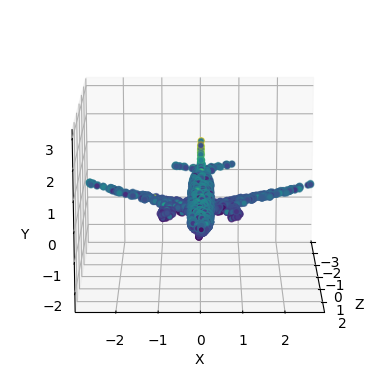

In [170]:
input_np = input[5, :, :].squeeze().detach().transpose(0,1).cpu().numpy()
fig = visualize_pointcloud(input_np)

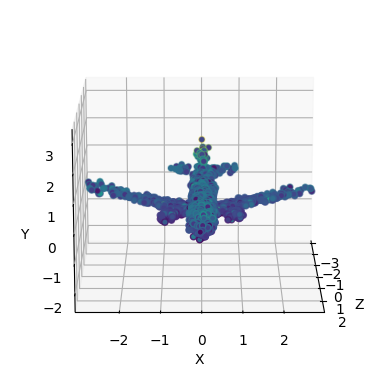

In [172]:
from visuals.visuals_util import rotate_point_cloud_z, rotate_point_cloud_y, rotate_point_cloud_x
output_np = output[5, :, :].squeeze().detach().transpose(0,1).cpu().numpy()
fig = visualize_pointcloud(rotate_point_cloud_y(output_np, 360))

# Let's try Point Transformer

In [45]:
import torch
import torch.nn as nn

from lib.pointops.functions import pointops


class PointTransformerLayer(nn.Module):
    def __init__(self, in_planes, out_planes, share_planes=8, nsample=16):
        super().__init__()
        self.mid_planes = mid_planes = out_planes // 1
        self.out_planes = out_planes
        self.share_planes = share_planes
        self.nsample = nsample
        self.linear_q = nn.Linear(in_planes, mid_planes)
        self.linear_k = nn.Linear(in_planes, mid_planes)
        self.linear_v = nn.Linear(in_planes, out_planes)
        self.linear_p = nn.Sequential(nn.Linear(3, 3), nn.BatchNorm1d(3), nn.ReLU(inplace=True), nn.Linear(3, out_planes))
        self.linear_w = nn.Sequential(nn.BatchNorm1d(mid_planes), nn.ReLU(inplace=True),
                                    nn.Linear(mid_planes, mid_planes // share_planes),
                                    nn.BatchNorm1d(mid_planes // share_planes), nn.ReLU(inplace=True),
                                    nn.Linear(out_planes // share_planes, out_planes // share_planes))
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, pxo) -> torch.Tensor:
        p, x, o = pxo  # (n, 3), (n, c), (b)
        x_q, x_k, x_v = self.linear_q(x), self.linear_k(x), self.linear_v(x)  # (n, c)
        x_k = pointops.queryandgroup(self.nsample, p, p, x_k, None, o, o, use_xyz=True)  # (n, nsample, 3+c)
        x_v = pointops.queryandgroup(self.nsample, p, p, x_v, None, o, o, use_xyz=False)  # (n, nsample, c)
        p_r, x_k = x_k[:, :, 0:3], x_k[:, :, 3:]
        for i, layer in enumerate(self.linear_p): p_r = layer(p_r.transpose(1, 2).contiguous()).transpose(1, 2).contiguous() if i == 1 else layer(p_r)    # (n, nsample, c)
        w = x_k - x_q.unsqueeze(1) + p_r.view(p_r.shape[0], p_r.shape[1], self.out_planes // self.mid_planes, self.mid_planes).sum(2)  # (n, nsample, c)
        for i, layer in enumerate(self.linear_w): w = layer(w.transpose(1, 2).contiguous()).transpose(1, 2).contiguous() if i % 3 == 0 else layer(w)
        w = self.softmax(w)  # (n, nsample, c)
        n, nsample, c = x_v.shape; s = self.share_planes
        x = ((x_v + p_r).view(n, nsample, s, c // s) * w.unsqueeze(2)).sum(1).view(n, c)
        return x


class TransitionDown(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, nsample=16):
        super().__init__()
        self.stride, self.nsample = stride, nsample
        if stride != 1:
            self.linear = nn.Linear(3+in_planes, out_planes, bias=False)
            self.pool = nn.MaxPool1d(nsample)
        else:
            self.linear = nn.Linear(in_planes, out_planes, bias=False)
        self.bn = nn.BatchNorm1d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, pxo):
        p, x, o = pxo  # (n, 3), (n, c), (b)
        if self.stride != 1:
            n_o, count = [o[0].item() // self.stride], o[0].item() // self.stride
            for i in range(1, o.shape[0]):
                count += (o[i].item() - o[i-1].item()) // self.stride
                n_o.append(count)
            n_o = torch.cuda.IntTensor(n_o)
            idx = pointops.furthestsampling(p, o, n_o)  # (m)
            n_p = p[idx.long(), :]  # (m, 3)
            x = pointops.queryandgroup(self.nsample, p, n_p, x, None, o, n_o, use_xyz=True)  # (m, 3+c, nsample)
            x = self.relu(self.bn(self.linear(x).transpose(1, 2).contiguous()))  # (m, c, nsample)
            x = self.pool(x).squeeze(-1)  # (m, c)
            p, o = n_p, n_o
        else:
            print(self.linear(x).shape)
            x = self.relu(self.bn(self.linear(x)))  # (n, c)
        return [p, x, o]


class TransitionUp(nn.Module):
    def __init__(self, in_planes, out_planes=None):
        super().__init__()
        if out_planes is None:
            self.linear1 = nn.Sequential(nn.Linear(2*in_planes, in_planes), nn.BatchNorm1d(in_planes), nn.ReLU(inplace=True))
            self.linear2 = nn.Sequential(nn.Linear(in_planes, in_planes), nn.ReLU(inplace=True))
        else:
            self.linear1 = nn.Sequential(nn.Linear(out_planes, out_planes), nn.BatchNorm1d(out_planes), nn.ReLU(inplace=True))
            self.linear2 = nn.Sequential(nn.Linear(in_planes, out_planes), nn.BatchNorm1d(out_planes), nn.ReLU(inplace=True))
        
    def forward(self, pxo1, pxo2=None):
        if pxo2 is None:
            _, x, o = pxo1  # (n, 3), (n, c), (b)
            x_tmp = []
            for i in range(o.shape[0]):
                if i == 0:
                    s_i, e_i, cnt = 0, o[0], o[0]
                else:
                    s_i, e_i, cnt = o[i-1], o[i], o[i] - o[i-1]
                x_b = x[s_i:e_i, :]
                x_b = torch.cat((x_b, self.linear2(x_b.sum(0, True) / cnt).repeat(cnt, 1)), 1)
                x_tmp.append(x_b)
            x = torch.cat(x_tmp, 0)
            x = self.linear1(x)
        else:
            p1, x1, o1 = pxo1; p2, x2, o2 = pxo2
            x = self.linear1(x1) + pointops.interpolation(p2, p1, self.linear2(x2), o2, o1)
        return x


class PointTransformerBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, share_planes=8, nsample=16):
        super(PointTransformerBlock, self).__init__()
        self.linear1 = nn.Linear(in_planes, planes, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.transformer2 = PointTransformerLayer(planes, planes, share_planes, nsample)
        self.bn2 = nn.BatchNorm1d(planes)
        self.linear3 = nn.Linear(planes, planes * self.expansion, bias=False)
        self.bn3 = nn.BatchNorm1d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, pxo):
        p, x, o = pxo  # (n, 3), (n, c), (b)
        identity = x
        x = self.relu(self.bn1(self.linear1(x)))
        x = self.relu(self.bn2(self.transformer2([p, x, o])))
        x = self.bn3(self.linear3(x))
        x += identity
        x = self.relu(x)
        return [p, x, o]


class PointTransformerSeg(nn.Module):
    def __init__(self, block, blocks, c=6, k=13):
        super().__init__()
        self.c = c
        self.in_planes, planes = c, [32, 64, 128, 256, 512]
        fpn_planes, fpnhead_planes, share_planes = 128, 64, 8
        stride, nsample = [1, 4, 4, 4, 4], [8, 16, 16, 16, 16]
        self.enc1 = self._make_enc(block, planes[0], blocks[0], share_planes, stride=stride[0], nsample=nsample[0])  # N/1
        self.enc2 = self._make_enc(block, planes[1], blocks[1], share_planes, stride=stride[1], nsample=nsample[1])  # N/4
        self.enc3 = self._make_enc(block, planes[2], blocks[2], share_planes, stride=stride[2], nsample=nsample[2])  # N/16
        self.enc4 = self._make_enc(block, planes[3], blocks[3], share_planes, stride=stride[3], nsample=nsample[3])  # N/64
        self.enc5 = self._make_enc(block, planes[4], blocks[4], share_planes, stride=stride[4], nsample=nsample[4])  # N/256
        self.dec5 = self._make_dec(block, planes[4], 2, share_planes, nsample=nsample[4], is_head=True)  # transform p5
        self.dec4 = self._make_dec(block, planes[3], 2, share_planes, nsample=nsample[3])  # fusion p5 and p4
        self.dec3 = self._make_dec(block, planes[2], 2, share_planes, nsample=nsample[2])  # fusion p4 and p3
        self.dec2 = self._make_dec(block, planes[1], 2, share_planes, nsample=nsample[1])  # fusion p3 and p2
        self.dec1 = self._make_dec(block, planes[0], 2, share_planes, nsample=nsample[0])  # fusion p2 and p1
        self.cls = nn.Sequential(nn.Linear(planes[0], planes[0]), nn.BatchNorm1d(planes[0]), nn.ReLU(inplace=True), nn.Linear(planes[0], k))

    def _make_enc(self, block, planes, blocks, share_planes=8, stride=1, nsample=16):
        layers = []
        layers.append(TransitionDown(self.in_planes, planes * block.expansion, stride, nsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, self.in_planes, share_planes, nsample=nsample))
        return nn.Sequential(*layers)

    def _make_dec(self, block, planes, blocks, share_planes=8, nsample=16, is_head=False):
        layers = []
        layers.append(TransitionUp(self.in_planes, None if is_head else planes * block.expansion))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, self.in_planes, share_planes, nsample=nsample))
        return nn.Sequential(*layers)

    def forward(self, pxo):
        p0, x0, o0 = pxo  # (n, 3), (n, c), (b)
        x0 = p0 if self.c == 3 else torch.cat((p0, x0), 1)
        p1, x1, o1 = self.enc1([p0, x0, o0])
        p2, x2, o2 = self.enc2([p1, x1, o1])
        p3, x3, o3 = self.enc3([p2, x2, o2])
        p4, x4, o4 = self.enc4([p3, x3, o3])
        p5, x5, o5 = self.enc5([p4, x4, o4])
        x5 = self.dec5[1:]([p5, self.dec5[0]([p5, x5, o5]), o5])[1]
        x4 = self.dec4[1:]([p4, self.dec4[0]([p4, x4, o4], [p5, x5, o5]), o4])[1]
        x3 = self.dec3[1:]([p3, self.dec3[0]([p3, x3, o3], [p4, x4, o4]), o3])[1]
        x2 = self.dec2[1:]([p2, self.dec2[0]([p2, x2, o2], [p3, x3, o3]), o2])[1]
        x1 = self.dec1[1:]([p1, self.dec1[0]([p1, x1, o1], [p2, x2, o2]), o1])[1]
        x = self.cls(x1)
        return x


def pointtransformer_seg_repro(**kwargs):
    model = PointTransformerSeg(PointTransformerBlock, [2, 3, 4, 6, 3], **kwargs)
    return model

In [46]:
model = pointtransformer_seg_repro(c = 3, k=3).to("cuda")

In [14]:
for batch in train_loader_20:
    input = batch["train_points"].to("cuda").transpose(1,2)

In [38]:
input.shape

torch.Size([20, 3, 2048])

In [47]:
input_tensor = input.transpose(1, 2)

# Assuming all features are coordinates
p0 = input_tensor  # Point coordinates
x0 = input_tensor  # Feature data (same as coordinates in this case)

# Create batch indices
o0 = torch.arange(20, dtype=torch.int32).to(input_tensor.device)

# Prepare the input for the model
pxo = (p0, x0, o0)

# Forward pass
output = model(pxo)

torch.Size([20, 2048, 32])


RuntimeError: running_mean should contain 2048 elements not 32

In [32]:
output = model(input)
output.shape

ValueError: too many values to unpack (expected 3)

In [3]:
import torch.optim as optim


optimizer= optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)
model.train()

# Run a fixed number of iterations with this sample
for iteration in range(500):  # Define number_of_iterations
    for batch in train_loader_20:
        input = batch["train_points"].to("cuda").transpose(1,2)
        optimizer.zero_grad()
        output = model(input).to("cuda")
        total_loss = chamfer_distance(input, output)
        print(f"Iteration {iteration}, Total Loss: {total_loss.item():.4f}")

        total_loss.backward()
        optimizer.step()